Modelo desenvolvido por: [Gabriel Pacheco](https://linkedin.com/in/gabriel-pacheco37)

## Otimização do planejamento da manutenção de caminhões

**Hipótese:** É possível prever que um caminhão terá uma avaria no sistema de ar e com isso reduzir os custos da manutenção.

**Conclusão:** Sim. Utilizando um modelo de Random Forest com: Recall de 98%, acurácia de 96% e ROC AUC de 99%, podemos alcançar uma redução de custos de 64% na manutenção do sistema de ar.\*

\*Quando testado utilizando os dados do ano corrente, as decisões previstas pelo modelo resultariam em um custo de $13.000, uma **redução de 64% nos custos**, quando comparado com os valores apresentados no relatório inicial da empresa.

---
Para alcançarmos estes resultados seguimos os seguintes passos:
 1. Tratamento e análise inicial dos dados
 2. Criação do modelo baseline
 3. Refinamento das soluções

---


### Tratamento e análise inicial dos dados

Na análise inicial do dataset previous_years pudemos identificar uma série de anomalias nos dados que precisaram ser tratadas:
 - 99% das linhas no dataset previous_years apresentam valores nulos.
    - Foram excluídas 24 colunas que possuiam mais de 20% de valores ausentes.
    - Foram excluídas 4823 linhas com mais de 10 valores ausentes.
    - Foi utilizada a mediana de cada coluna para imputar os valores ausentes dos 7312 registros que sobraram.
 - A coluna cd_000 possuia um valor constante, fato que não agrega valor ao modelo.
    - A coluna foi excluída.
 - Foram identificadas 42 colunas que apresentavam pelo menos 75% de valores como 0.0.
    - Por se tratarem de um indício de enviesamento as colunas foram excluídas.
 - A coluna class foi convertida de string para int.

No dataset do present_year foi aplicado o seguinte tratamento, visando manter a consistência com o dataset anterior.
 - Foram filtradas as mesmas colunas utilizadas no dataset de previous_years.
 - Foram excluídas linhas com mais de 10 valores ausentes.
 - Foi utilizada a mediana para inserir os valores ausentes restantes.
 - A coluna class foi convertida a int.


Importação das bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump
import warnings


warnings.filterwarnings('ignore')
pd.set_option("max_columns", None)

In [2]:
df_previous_years_raw = pd.read_csv('../data/raw/air_system_previous_years.csv')
df_present_year_raw = pd.read_csv('../data/raw/air_system_present_year.csv')

Análise e tratamento do dataset dos anos anteriores

In [3]:
df_previous_years_raw.shape

(60000, 171)

In [4]:
df_previous_years_raw.head(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

Existem valores nulos no dataset? Qual a sua proporção?

Como os valores nulos estão no formato de uma string "na" vamos converter primeiro os valores em valores nulos, dessa forma fica mais fácil identificar e decidir qual será o tratamento ideal.

In [5]:
df_previous_years = df_previous_years_raw.replace('na', np.NaN)
null_rows = len(df_previous_years[df_previous_years.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(df_previous_years)}. Equivalente a {round(null_rows/len(df_previous_years)*100, 2)}% do dataset.")

Existem 59409 linhas com valores nulos de um total de 60000. Equivalente a 99.02% do dataset.


Vamos identificar as colunas com maior quantidade de valores nulos.

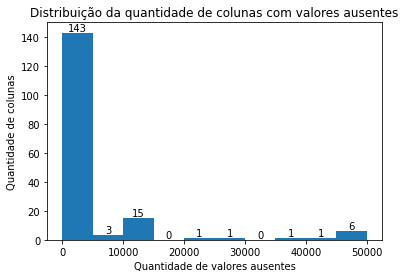

In [6]:
nulls_by_column = df_previous_years.isnull().sum().sort_values(ascending=False)

nulls_by_column.groupby(nulls_by_column).count()
bins = np.arange(0, 50001, 5000)

values, bins, bars = plt.hist(nulls_by_column.groupby(nulls_by_column).count().index, weights=nulls_by_column.groupby(nulls_by_column).count().values, bins=bins)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel('Quantidade de colunas')
plt.title('Distribuição da quantidade de colunas com valores ausentes')
plt.bar_label(bars)

plt.show()

Podemos ver que temos uma grande quantidade de missing-values no dataset como um todo, e em algumas colunas chegamos a mais de 80% de valores ausentes. 

Por enquanto, vamos definir um limite de 20% de valores ausentes por coluna. Isso quer dizer que colunas com mais de 12k valores ausentes serão excluídas. Esse limite pode ser alterado futuramente caso necessário.

In [7]:
df_previous_years = df_previous_years.drop(columns=nulls_by_column[nulls_by_column>12000].index)

df_previous_years[df_previous_years.isna().any(axis=1)]

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
12,neg,2104,36,0,0,0,0,9744,13148,98310,22210,1336,0,0,0,59062,0,0,0,15238,24218,109858,108074,38530,7392,0,0,0,0,200,114,0,0,0,0,0,0,0,12260,132488,0,1122,104,170,422,14502,128428,0,0,0,0,37860,30084,20616,13598,18688,14228,6174,2628,780,92,163728,30,34,18,0,59062,1418,12002,26016,37660,2104.31,163728,163728,164244,1041.0,0,15712,162960,144748,1209600,2776,104222.4,0,39421.44,NaN,NaN,9652,3180,50254,79052,1554,1024,32,0,0,0,48,163728,1134,60,8200,4040,13246,116456,1612,0,0,0,476,214,0,0,0,0,0,0,0,0,1216,206,24,0,0,1888,382,500,86,0,0,0,0,1100350,NaN,NaN,41704,15418,4776,2330,4634,6534,29980,39372,0,0,0,0
14,neg,24416,0,0,0,0,0,0,0,556,448484,887798,128906,2188,0,716912,0,64,0,0,0,1388178,1296724,145126,65574,0,0,0,0,0,0,0,0,0,0,0,3472,317156,427416,719888,0,3050,1256,954,990,223308,1238362,8,4,0,0,540106,277452,178208,129534,96068,79586,95176,71802,0,0,1533608,56,320,416,146,716912,11766,70222,74334,23020,24416.97,1533608,1533608,1519186,9063.0,239974,30692,320440,1467932,1209600,0,1313301.12,0,152134.08,NaN,NaN,0,0,0,163278,752510,476802,67208,6894,1240,0,0,1533608,2582,280,52304,53400,90994,1114128,152128,2116,0,0,940,68,0,0,0,0,0,0,0,0,6264,24720,4746,0,0,54524,8174,2173160,483828,0,0,0,0,1074940,NaN,NaN,163678,199404,190606,95674,207476,232470,154962,99406,121544,2712,0,0
23,pos,453236,2926,0,0,0,0,222,323436,2999280,20657518,12530224,913700,12670,0,18489312,19038,0,NaN,117902,203782,32633282,28658284,5348896,3667892,0,0,0,0,24514,1858,2273870,2608460,1424956,1607946,1409344,2051868,2227058,8113476,15720072,0,28828,33264,47402,627172,26128758,10570790,804,22,8,2,12630142,9040546,7110184,4970218,2616558,886208,160242,22100,842,10,38100406,632,1686,2018,684,18489312,447850,2507262,2827898,190440,453236.92,38100374,38100374,37843756,189372,8436120,NaN,565520,37437050,1209600,0,33480473.28,0,3935856.96,NaN,NaN,0,24598,523608,11350372,19808010,5225236,439104,59042,6950,130,42,38100374,16738,3392,1441482,1867216,1513156,21289878,11184234,120904,50,0,18132,2442,0,0,0,0,0,0,0,0,260830,169964,26740,73289586,16623244,1056682,155406,93686740,28423762,7966,382610,0,0,432739640,NaN,NaN,4079752,13176956,7908038,3026002,5025350,2025766,1160638,533834,493800,6914,0,0
28,neg,1870,NaN,0,0,0,0,0,0,140,68816,42816,0,0,0,35354,0,0,NaN,0,0,103758,96110,16470,4532,0,0,0,0,0,0,0,0,0,0,0,1856,75914,7718,26284,0,1008,66,48,92,84,108306,2168,0,0,0,58320,38386,9574,3932,864,266,428,2,0,0,120258,24,250,86,6,35354,972,7376,9028,16140,1869.83,120258,120258,NaN,358,5902,NaN,119920,NaN,1209600,0,100306.56,0,10453.44,NaN,NaN,0,0,0,35040,70368,5882,400,64,18,0,0,120258,978,16,6674,2780,11052,83616,6252,404,0,0,116,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,1288,330,0,0,3330,574,575220,75946,0,0,0,0,NaN,NaN,NaN,12252,11344,7688,5050,33502,40466,1436,34,0,0,0,0
32,neg,30694,0,0,0,0,0,0,0,1428,60474,1358772,458664,1640,0,941828,0,0,0,0,0,1730606,1595018,210252,105706,0,0,0,0,0,0,0,0,0,0,0,9282,537044,1317798,16854,0,3598,2206,3064,5514,879062,987426,106,2,0

De 59K linhas com valores nulos, caimos agora para apenas 12K, uma redução já considerável, mas que ainda precisamos melhorar. 

Vamos conferir as linhas com mais valores nulos para determinar quais valem a pena ser mantidas, os demais valores nulos serão preenchidos com a mediana de cada coluna.

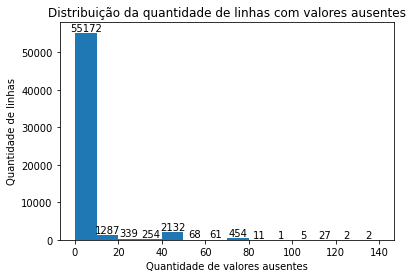

In [8]:
nulls_by_row = df_previous_years.isnull().sum(axis=1).sort_values(ascending=False)
bins = np.arange(0, 150, 10)

values, bins, bars = plt.hist(nulls_by_row.groupby(nulls_by_row).count().index, weights=nulls_by_row.groupby(nulls_by_row).count().values, bins=bins)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel('Quantidade de linhas')
plt.title('Distribuição da quantidade de linhas com valores ausentes')
plt.bar_label(bars)

plt.show()

In [9]:
df_previous_years_treated = df_previous_years.drop(index=nulls_by_row[nulls_by_row>10].index)


Buscando um equilibrio entre manter os dados puros e não perder uma grande quantidade de registros, optei por excluir todas as linhas com mais de 10 valores missing, o que representou uma redução de 4823 linhas. 

Sobraram então 7312 registros com valores missing que serão inseridos com base na mediana.

In [10]:
def impute_missing_values(dataset):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(dataset.iloc[:,:])
    dataset.iloc[:,:] = imputer.transform(dataset.iloc[:,:])

    return dataset

In [11]:
df_previous_years_treated.iloc[:,1:] = impute_missing_values(df_previous_years_treated.iloc[:,1:])

Perfeito, tratamos os valores nulos, agora vamos só transformar a coluna class em valores numéricos e podemos partir para a proxima etapa e converter a variável class para integer.

In [12]:
df_previous_years_treated['class'] = df_previous_years_treated['class'].replace({'neg':0, 'pos':1})

df_previous_years_treated.head(10)

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,2.130706e+09,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,5245752.00,0.00,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,240.0,6700214.0,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,2291079.36,0.00,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,0.0,3646660.0,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,2.280000e+02,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,28000.0,41040.08,2673338.0,2673338.0,2678534.0,15439.0,7466.0,22436.0,248240.0,2560566.0,1209600.0,63328.0,2322692.16,0.00,236099.52,0.0,0.0,0.0,0.0,0.0,33276.0,1215280.0,1102798.0,196502.0,10260.0,2422.0,28.0,6.0,2673338.0,3584.0,500.0,56362.0,149726.0,100326.0,1744838.0,488302.0,16682.0,246.0,0.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262

Analisando a tabela abaixo podemos encontrar a coluna cd_000 com desvio padrão de 0.0, o que simboliza que a coluna inteira é uma constante. Para o nosso modelo, essa coluna é irrelevante, então pode ser excluída.

Além disso, percebemos uma série de colunas com um comportamento suspeito, elas estão com o valor zerado até ao 3º quartil (75%), e do 3º para o 4º quartil elas apresentam uma variação.

Vamos analisar melhor estas colunas, uma distribuição tão atípica quanto esta pode ser um indício de um envisamento no modelo.

In [13]:
df_previous_years_treated.describe()

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,55177.000000,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,55177.0,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000
mean,0.008355,4.323073e+04,3.641478e+08,6.781558,10.779310,2.087882e+02,3.994962e+02,3.344786e+03,4.047865e+04,2.406512e+05,7.531389e+05,1.290804e+06,3.999014e+05,2.733643e+04,3.007456e+03,1.389427e+06,4.575251e+03,6.621107e+02,9.203161e+02,2.694342e+04,4.055936e+04,2.637171e+06,2.281630e+06,6.686076e+05,3.178046e+05,0.420284,1.463907,4.044165e+03,1.105271e+02,1064.476503,359.608714,4.186644e+03,7.077539e+03,9.513682e+03,5.673023e+03,5.631089e+03,6.233743e+04,8.710599e+05,1.080238e+06,7.124619e+05,1.111774e+03,4.838386e+03,2.557931e+03,4.189549e+03,6.474683e+04,1.109711e+06,1.467428e+06,9.249754e+04,1.267855e+04,6.118473e+02,30.965583,1.028466e+06,6.426439e+05,2.783140e+05,1.900267e+05,1.461279e+05,1.372335e+05,1.516381e+05,1.439438e+05,2.137820e+04,1.951938e+04,3.333023e+06,514.717255,848.882034,1205.199812,54.526777,1.389569e+06,4.228552e+04,3.485658e+05,3.176651e+05,7.657848e+04,4.328546e+04,3.333807e+06,3.333807e+06,3.058838e+06,16075.202512,8.033526e+04,39256.418073,3.971519e+05,2.821295e+06,1209600.0,6.235739e+04,2.531720e+06,5.591675e+04,4

In [14]:
columns_description = df_previous_years_treated.describe().transpose()
print('Colunas com pelo menos 75% dos valores iguais')
columns_description[columns_description['min']==columns_description['75%']]

Colunas com pelo menos 75% dos valores iguais


,count,mean,std,min,25%,50%,75%,max
class,55177.0,8.354930e-03,9.102349e-02,0.0,0.0,0.0,0.0,1.000000e+00
ae_000,55177.0,6.781558e+00,1.626371e+02,0.0,0.0,0.0,0.0,2.105000e+04
af_000,55177.0,1.077931e+01,2.067006e+02,0.0,0.0,0.0,0.0,2.007000e+04
ag_000,55177.0,2.087882e+02,2.114438e+04,0.0,0.0,0.0,0.0,3.376892e+06
ag_001,55177.0,3.994962e+02,1.969692e+04,0.0,0.0,0.0,0.0,3.708310e+06
ag_002,55177.0,3.344786e+03,7.924544e+04,0.0,0.0,0.0,0.0,9.042380e+06
ag_003,55177.0,4.047865e+04,4.555792e+05,0.0,0.0,0.0,0.0,6.340207e+07
ai_000,55177.0,4.575251e+03,8.542265e+04,0.0,0.0,0.0,0.0,9.329134e+06
aj_000,55177.0,6.621107e+02,4.073372e+04,0.0,0.0,0.0,0.0,4.262892e+06
ak_000,55177.0,9.203161e+02,7.531707e+04,0.0,0.0,0.0,0.0,1.044492e+07


Com mais de 75% dos dados com o valor igual a 0, essas colunas apresentam pouco valor preditivo para o nosso modelo, podendo assim ser descartadas.

In [15]:
low_variance_cols = columns_description[columns_description['min']==columns_description['75%']].index
low_variance_cols = low_variance_cols[1:] #Excluir a coluna 'class' da lista

df_previous_years_treated = df_previous_years_treated.drop(columns=low_variance_cols)

In [16]:
df_previous_years_treated.describe()

,class,aa_000,ac_000,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,av_000,ax_000,ay_005,ay_006,ay_007,ay_008,az_000,az_001,az_002,az_003,az_004,az_005,az_006,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,ce_000,ci_000,ck_000,cm_000,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,dd_000,de_000,dn_000,do_000,dp_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
count,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,55177.000000,5.517700e+04,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,55177.000000,55177.000000,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04,5.517700e+04
mean,0.008355,4.323073e+04,3.641478e+08,2.406512e+05,7.531389e+05,1.290804e+06,3.999014e+05,2.733643e+04,3.007456e+03,1.389427e+06,2.694342e+04,4.055936e+04,2.637171e+06,2.281630e+06,6.686076e+05,3.178046e+05,1064.476503,359.608714,6.233743e+04,8.710599e+05,1.080238e+06,7.124619e+05,4.838386e+03,2.557931e+03,4.189549e+03,6.474683e+04,1.109711e+06,1.467428e+06,9.249754e+04,1.028466e+06,6.426439e+05,2.783140e+05,1.900267e+05,1.461279e+05,1.372335e+05,1.516381e+05,1.439438e+05,2.137820e+04,1.951938e+04,3.333023e+06,514.717255,848.882034,1205.199812,54.526777,1.389569e+06,4.228552e+04,3.485658e+05,3.176651e+05,7.657848e+04,4.328546e+04,3.333807e+06,3.333807e+06,3.058838e+06,16075.202512,8.033526e+04,39256.418073,3.971519e+05,2.821295e+06,6.235739e+04,2.531720e+06,4.956693e+05,234.180909,8.585549e+04,3.222981e+05,9.024367e+05,1.039257e+06,3.350592e+05,4.698362e+04,1.293102e+04,3.048222e+03,415.995795,3.333807e+06,4568.067891,561.805027,1.314149e+05,2.521386e+05,2.505863e+05,1.626835e+06,4.796033e+05,1.338293e+04,1.840877e+02,2711.239176,360.203563,2.442311e+04,2.671868e+04,6559.969190,8.088158e+04,14089.589938,3.836739e+06,5.174071e+05,7.035612e+05,6.838118e+03,9.747018e+06,1096.854186,1186.081664,4.973156e+05,5.592764e+05,3.283570e+05,1.600785e+05,3.424147e+05,2.954380e+05,2.389808e+05,2.119436e+05,1.179621e+05,7.523834e+03
std,0.091023,9.105847e+04,8.020594e+08,1.573856e+06,2.056204e+06,2.350029e+06,9.313499e+05,1.519891e+05,8.256954e+04,2.944619e+06,1.976918e+05,2.952439e+05,5.241083e+06,4.584921e+06,1.726070e+06,7.732341e+05,5545.932843,1342.300003,6.669485e+05,1.911548e+06,3.395367e+06,2.489042e+06,3.994342e+04,1.471197e+04,4.072528e+04,3.450659e+05,2.536439e+06,4.127646e+06,8.399281e+05,2.449966e+06,1.356710e+06,6.556115e+05,4.124158e+05,3.052109e+05,2.876824e+05,3.555906e+05,3.580813e+05,1.826310e+05,2.582779e+05,6.946774e+06,3796.629647,4478.793785,7860.058425,3

Excluímos as colunas que possuiam mais de 75% dos valores zerados, e sobraram assim 105 colunas. Ainda sobraram algumas colunas de valores contínuos com 50% dos valores zerados, o que não é algo positivo, mas podemos partir para os proximos passos e dependendo do resultado dos primeiros modelos voltamos aqui para ver o que pode ser feito.

Vamos começar agora o tratamento dos dados do dataframe do ano corrente. Como usaremos o dataset dos anos anteriores para treinar o modelo e o dataset atual para testar, eles precisam estar alinhados em formato e tipo de dados. Então, podemos começar por remover as colunas que foram excluídas no dataframe dos anos anteriores, preencher os valores nulos e converter a coluna class de string para numérica.

In [17]:
df_present_year_raw

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,0,13124,2,1956,434,76,174,190,6198,1148,2948,2,0,8762,2566,480,380,196,516,86,66,74,0,124340,4,6,4,0,3976,318,107662,3458,na,na,na,na,na,na,na,na,110980,59.53,124340,124340,184970,54,686,12246,123880,13196,1209600,598,0,6,0,5913.6,0,5851.2,6,30,0,2,5512,4674,1388,1508,38,4,0,0,8,12,124340,0,1550,14,36,26,920,430,7650,2294,206,0,22,42,5336,1276,0,0,0,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,692,16286,0,280,44,50,1274,866,3362,11102,0,0,0,12564,1756,638,276,172,132,812,308,192,128,46894,4,2,38,0,5244,360,20520,3134,na,na,na,na,na,na,na,na,23320,81.89,46894,46894,48324,68,0,4486,46480,17050,1209600,726,2,4,0,7224.96,0,7768.32,0,42,0,0,4,7064,6200,2452,1246,12,0,0,14,54,46894,0,2202,28,114,350,700,1708,9622,2174,80,0,80,206,7802,1466,0,0,0,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,2808472,474782,0,22984,894,1162,1304,1856,388700,3424812,123828,23260,0,1662580,667960,387998,226078,161558,148288,154908,220820,147744,210866,4644422,958,7848,3624,0,1891670,47066,692800,265492,336240,194360,245240,na,na,na,na,na,175480,66002.89,4644422,4644422,4608738,22706,2272,95510,1006260,3991552,1209600,126310,0,104,0,3594885.12,0,374649.6,148,720,0,5154,174956,622312,1002504,793938,541734,345896,300806,201500,52,92,4644422,0,24818,964,162660,215004,217930,3038612,322718,6080,14,0,226,572,3593728,1911060,0,284,0,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,2930694,2012,0,3526,904,1426,223226,2663348,1137664,104,0,0,0,1283806,928212,345132,265930,194770,158262,219942,620264,13880,0,4201350,98,238,880,16,1772828,51468,331744,316130,176000,208420,159380,na,na,na,na,na,100120,59816.46,4201350,4201350,4203050,29967.0,26214,51894,562680,4030198,1209600,114684,0,144,0,3387773.76,38633.28,599624.64,0,0,0,0,14308,475410,1109740,1528024,837114,58942,6220,440,1278,1292,4201350,na,6846,810,70090,345884,191284,2454600,926846,33558,280,0,1516,1398,2050280,64066,0,674,0,46,3413978,2924,414,0,0,60,387

In [18]:
df_present_year = df_present_year_raw[df_previous_years_treated.columns.to_list()]

df_present_year = df_present_year.replace('na', np.NaN)

nulls_by_row = df_present_year.isnull().sum(axis=1).sort_values(ascending=False)
print(f'Foram identificadas e excluídas {len(nulls_by_row[nulls_by_row>10])} linhas com mais de 10 valores nulos.')
df_present_year = df_present_year.drop(index=nulls_by_row[nulls_by_row>10].index)

df_present_year['class'] = df_present_year['class'].replace({'neg':0, 'pos':1})
print('A coluna class foi convertida de string para numérica.')


df_present_year_treated = impute_missing_values(df_present_year)
print('Foi imputada a mediana das colunas nos valores nulos.')

Foram identificadas e excluídas 990 linhas com mais de 10 valores nulos.
A coluna class foi convertida de string para numérica.
Foi imputada a mediana das colunas nos valores nulos.


In [19]:
df_present_year_treated.head(10)

,class,aa_000,ac_000,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,av_000,ax_000,ay_005,ay_006,ay_007,ay_008,az_000,az_001,az_002,az_003,az_004,az_005,az_006,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,ce_000,ci_000,ck_000,cm_000,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,dd_000,de_000,dn_000,do_000,dp_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
0,0.0,60.0,2.000000e+01,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,58.0,26.0,0.0,0.0,0.0,13124.0,1956.0,434.0,76.0,174.0,190.0,6198.0,1148.0,8762.0,2566.0,480.0,380.0,196.0,516.0,86.0,66.0,74.0,0.0,124340.0,4.0,6.0,4.0,0.0,3976.0,318.0,107662.0,3458.0,110980.0,59.53,124340.0,124340.0,184970.0,54.0,686.0,12246.0,123880.0,13196.0,598.0,5913.60,5851.20,30.0,5512.0,4674.0,1388.0,1508.0,38.0,4.0,0.0,0.0,12.0,124340.0,1550.0,14.0,36.0,26.0,920.0,430.0,7650.0,2294.0,206.0,70.0,112.0,340.0,0.0,0.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0
1,0.0,82.0,6.800000e+01,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,12.0,82.0,0.0,0.0,692.0,16286.0,280.0,44.0,50.0,1274.0,866.0,3362.0,11102.0,12564.0,1756.0,638.0,276.0,172.0,132.0,812.0,308.0,192.0,128.0,46894.0,4.0,2.0,38.0,0.0,5244.0,360.0,20520.0,3134.0,23320.0,81.89,46894.0,46894.0,48324.0,68.0,0.0,4486.0,46480.0,17050.0,726.0,7224.96,7768.32,42.0,4.0,7064.0,6200.0,2452.0,1246.0,12.0,0.0,0.0,54.0,46894.0,2202.0,28.0,114.0,350.0,700.0,1708.0,9622.0,2174.0,80.0,78.0,40.0,352.0,0.0,0.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0
2,0.0,66002.0,2.120000e+02,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,106.0,340.0,24286.0,681260.0,2808472.0,474782.0,22984.0,894.0,1162.0,1304.0,1856.0,388700.0,3424812.0,1662580.0,667960.0,387998.0,226078.0,161558.0,148288.0,154908.0,220820.0,147744.0,210866.0,4644422.0,958.0,7848.0,3624.0,0.0,1891670.0,47066.0,692800.0,265492.0,175480.0,66002.89,4644422.0,4644422.0,4608738.0,22706.0,2272.0,95510.0,1006260.0,3991552.0,126310.0,3594885.12,374649.60,720.0,174956.0,622312.0,1002504.0,793938.0,541734.0,345896.0,300806.0,201500.0,92.0,4644422.0,24818.0,964.0,162660.0,215004.0,217930.0,3038612.0,322718.0,6080.0,14.0,4218.0,692.0,25278.0,9438.0,2504.0,109700.0,19072.0,9520.0,4902.0,4434614.0,70900.0,26002880.0,2057.84,2158.0,396312.0,538136.0,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0
3,0.0,59816.0,1.010000e+03,123922.0,984314.0,1680050.0,1135268.0,92606.0,14038.0,1772828.0,1116.0,2372.0,3546760.0,3053176.0,652616.0,423374.0,1622.0,432.0,6388.0,1091104.0,2930694.0,2012.0,3526.0,904.0,1426.0,223226.0,2663348.0,1137664.0,104.0,1283806.0,928212.0,345132.0,265930.0,194770.0,158262.0,219942.0,620264.0,13880.0,0.0,4201350.0,98.0,238.0,880.0,16.0,1772828.0,51468.0,331744.0,316130.0,100120.0,59816.46,4201350.0,4201350.0,4203050.0,29967.0,26214.0,51894.0,562680.0,4030198.0,114684.0,3387773.76,599624.64,0.0,14308.0,475410.0,1109740.0,1528024.0,837114.0,58942.0,6220.0,440.0,1292.0,4201350.0,6846.0,810.0,70090.0,345884.0,191284.0,2454600.0,926846.0,33558.0,280.0,2924.0,414.0,27740.0,33354.0,6330.0,133542.0,21290.0,2718360.0,435370.0,0.0,0.0,1179900.0,1541.32,1678.0,659550.0,691580.0,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0
4,0.0,1814.0,1.560000e+02,72.0,17926.0,82834.0,3114.0,0.0,0.0,48978.0,0.0,0.0,97146.0,89920.0,12932.0,5092.0,102.0,50.0,11544.0,73570.0,3662.0,15170.0,126.0,34.0,60.0,58.0,10768.0,92898.0,2.0,53558.0,34620.0,9824.0,4552.0,764.0,294

O segundo dataframe foi tratado e está conforme o formato do primeiro dataframe. Podemos então partir para o treinamento dos modelos.

---
### Criação do modelo baseline

Já estamos prontos para começar a treinar o primeiro modelo, esse será um modelo baseline sem muito pré-processamento e sem configurar os hiper-parâmetros.

Mas antes de sequer escrevermos a primeira linha de código do primeiro modelo, precisamos rever o problema do negócio, afinal, é com base nele que vamos definir e avaliar o modelo. 

Como vimos na descrição, a nossa meta é auxiliar a empresa de transporte a reduzir os gastor com a manutenção do sistema de ar do seus caminhões, para isso, vamos utilizar a variável _class_ para classificar se um veículo está propenso ou não a ter problemas no sistema de ar. Vamos visualizar possiveis resultados sobre a luz da matriz de confusão:
- Verdadeiro Negativo: Nosso modelo **previu corretamente** que um caminhão **não teria um problema** no sistema de ar e **não foi** enviado para manutenção. **Gasto de $0**
- Verdadeiro Positivo: Nosso modelo **previu corretamente** que um caminhão **teria um problema** no sistema de ar, **foi** enviado para manutenção e **teve reparo preventivo**. **Gasto de $25**
- Falso Positivo: Nosso modelo **previu erroneamente** que um caminhão **teria um problema** no sistema de ar, **foi** enviado para manutenção e não **teve reparo preventivo**. **Gasto de $10**
- Falso Negativo: Nosso modelo **previu erroneamente** que um caminhão **não teria um problema** no sistema de ar, **não foi** enviado para manutenção e eventualmente quebrou e precisou de **reparo corretivo**. **Gasto de $500**

O pior cenário seria um falso negativo visto que traria a maior despesa para a empresa, com base nisso, podemos definir um threshold menor, para favorecer classificações positivas (lembrando que é melhor errar classificando positivamente, do que errar classificando negativamente), além de utilizar o *recall* como principal métrica para avaliar os modelos, visto que ele consegue identificar claramente os falsos negativos e um recall melhor significa uma quantidade menor de FNs.

In [20]:
# Essas funções vão nos ajudar a avaliar os modelos lá na frente.

def get_model_metrics(X, y, trained_model):

    results = trained_model.predict(X)

    tn, fp, fn, tp = confusion_matrix(y, results).ravel()
    score = trained_model.score(X, y)
    try :
        roc = roc_auc_score(y, trained_model.predict_proba(X)[:,1])
    except :
        roc = 0
    recall = tp/(tp+fn)

    metrics = {
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'recall': round(recall, 2),
        'score': round(score, 2),
        'roc_auc':round(roc, 2)
    }

    return metrics

def get_model_train_test_metrics(X_train, y_train, X_test, y_test, model):

    train_metrics = get_model_metrics(X_train, y_train, model)
    test_metrics = get_model_metrics(X_test, y_test, model)

    metrics = [{'dataset':'train', 'metrics':train_metrics},
                {'dataset':'test', 'metrics': test_metrics}]

    return metrics

Para compararmos o impacto de cada modelo em relação ao problema de negócio, iremos criar uma _função de custo_, que irá nos retornar o custo das decisões tomadas por cada modelo. A função segue a lógica de somar a multiplicação dos possíveis resultados da matriz de confusão pelo custo atrelado a esse resultado, de acordo com a seguinte fórmula:

Custo = (TN * 0) + (FP * 10) + (FN * 500) + (TP * 25)

In [21]:
def calculate_cost(metrics):
    fp_cost = metrics['false_positives']*10
    fn_cost = metrics['false_negatives']*500
    tp_cost = metrics['true_positives']*25

    return fp_cost + fn_cost + tp_cost

def calculate_models_costs(models_metrics):
    costs = []
    for model, _ in enumerate(models_metrics):
        cost = calculate_cost(models_metrics[model][2]['metrics'])
        costs.append(f'Modelo {model} {models_metrics[model][0]} tem o custo de: ${cost}')

    return costs

#### Separando os dados de treino e teste

In [22]:
X_train = df_previous_years_treated.drop(columns='class')
y_train = df_previous_years_treated['class']

X_test = df_present_year_treated.drop(columns='class')
y_test = df_present_year_treated['class']

In [23]:
y_train.value_counts()

0    54716
1      461
Name: class, dtype: int64

In [24]:
y_test.value_counts()

0.0    14787
1.0      223
Name: class, dtype: int64

Claramente as classes estão longe de estarem balanceadas, mas como este ainda é o nosso primeiro modelo, vamos manter as coisas assim por enquanto.

#### Treinando o primeiro modelo (baseline)

In [25]:
lr_model0 = LogisticRegression(random_state=42)
lr_model0.fit(X_train, y_train)
metrics_lr_model0 = get_model_train_test_metrics(X_train, y_train, X_test, y_test, lr_model0)

metrics_lr_model0

[{'dataset': 'train',
  'metrics': {'true_negatives': 54420,
   'false_positives': 296,
   'false_negatives': 209,
   'true_positives': 252,
   'recall': 0.55,
   'score': 0.99,
   'roc_auc': 0.71}},
 {'dataset': 'test',
  'metrics': {'true_negatives': 14682,
   'false_positives': 105,
   'false_negatives': 97,
   'true_positives': 126,
   'recall': 0.57,
   'score': 0.99,
   'roc_auc': 0.7}}]

In [26]:
model0_costs = calculate_cost(metrics_lr_model0[1]['metrics'])

print(f'O modelo 0 custa: ${model0_costs}')

O modelo 0 custa: $52700


Este será nosso modelo de baseline utilizado para comparar com os demais modelos, analisando os resultados, podemos perceber uma clara dificuldade em prever valores positivos, isso fica claro pela taxa de recall de 54%, em outras palavras, de todos os eventos positivos, o nosso modelo conseguiu prever apenas 54% deles corretamente.

A culpa disso é principalmente de o dataset possuir classes desbalanceadas, o que pode ser corrigido usando undersampling ou oversampling. Algo que será levado em consideração nos próximos modelos.

---
### Refinamento das soluções

O modelo com melhores resultados foi um Random Forest com recall de 98%, accuracy de 96% e roc auc de 99%. O modelo também apresentou uma redução de 64% nas despesas da empresa com manutenção, quando avaliado seu desempenho em relação as gastos no ano corrente.

Os resultados foram alcançados utilizando o seguinte conjunto de hiper-parâmetros, além de um undersample da classe dominante para que fosse alcançado o balanceamento do dataset:
    
    max_depth=11, max_features=10, min_samples_leaf=2, n_estimators=50, random_state=42

Abaixo vamos criar uma série de funções que irão nos auxiliar a automatizar o processo de treinamento e avaliação dos modelos:

In [27]:
def undersample(X_train, y_train):
    print('-'*36, '\nRealizando o undersampling\n', '-'*36)
    rus = RandomUnderSampler(random_state=42, sampling_strategy=0.60)
    X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

    return X_undersampled, y_undersampled

def oversample(X_train, y_train):
    print('-'*36, '\nRealizando o oversampling\n', '-'*36)
    smt = SMOTE(random_state=42)
    X_oversampled, y_oversampled = smt.fit_resample(X_train, y_train)

    return X_oversampled, y_oversampled

def train_lr_model(X_train, y_train, X_test, y_test, parameters):
    estimator = LogisticRegression(random_state=42)
    clf = GridSearchCV(estimator, parameters, scoring='recall')

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0,'Logistic Regression Model')

    return models, metrics


def train_knn_model(X_train, y_train, X_test, y_test, parameters):
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, parameters, scoring='recall')

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0,'KNN Model')

    return models, metrics

def train_rf_model(X_train, y_train, X_test, y_test, parameters):
    estimator = RandomForestClassifier(random_state=42)
    clf = GridSearchCV(estimator, parameters, scoring='recall')

    models = clf.fit(X_train, y_train)
    metrics = get_model_train_test_metrics(X_train, y_train, X_test, y_test, models.best_estimator_)
    metrics.insert(0,'Random Forest Model')

    return models, metrics


def train_models(X_train, y_train, X_test, y_test, estimators):
    all_models = []
    all_metrics = []

    _X_train_u, _y_train_u = undersample(X_train, y_train)
    _X_train_o, _y_train_o = oversample(X_train, y_train)
    _X_train_uo, _y_train_uo = oversample(_X_train_u, _y_train_u)

    for estimator in estimators:
        _X_train = X_train.copy()
        _y_train = y_train.copy()

        if estimator['undersample'] == True:
            _X_train, _y_train = _X_train_u, _y_train_u
        
        if estimator['oversample'] == True:
            _X_train, _y_train = _X_train_o, _y_train_o

        if estimator['undersample'] == True and estimator['oversample'] == True:
            _X_train, _y_train = _X_train_uo, _y_train_uo
        
        if estimator['estimator'] == 'LogisticRegression':
            print('-'*36, '\nTraining Logistic Regression Model\n', '-'*36)
            models, model_metrics = train_lr_model(_X_train, _y_train, X_test, y_test, estimator['parameters'])
        
        if estimator['estimator'] == 'KNN':
            print('-'*36, '\nTraining KNN Model\n', '-'*36)
            models, model_metrics = train_knn_model(_X_train, _y_train, X_test, y_test, estimator['parameters'])

        if estimator['estimator'] == 'RandomForest':
            print('-'*36, '\nTraining Random Forest Model\n', '-'*36)
            models, model_metrics = train_rf_model(_X_train, _y_train, X_test, y_test, estimator['parameters'])
        
        all_models.append(models)
        all_metrics.append(model_metrics)
    
    return all_models, all_metrics

Vamos definir agora os algoritmos e os hiper-parâmetros a serem testados:

In [29]:
estimators = [{'estimator':'LogisticRegression',
               'undersample':True,
               'oversample':True,
               'parameters':{'C':(100, 10, 1.0, 0.1, 0.01),
                             'max_iter':(100, 200, 500, 700, 1000),
                             'solver':('lbfgs', 'liblinear', 'sag', 'saga')
                            }
                },
                {'estimator':'LogisticRegression',
               'undersample':True,
               'oversample':False,
               'parameters':{'C':(100, 10, 1.0, 0.1, 0.01),
                             'max_iter':(100, 200, 500, 700),
                             'solver':('lbfgs', 'liblinear', 'sag', 'saga')
                            }
                },
                {'estimator':'LogisticRegression',
               'undersample':False,
               'oversample':True,
               'parameters':{'C':(100, 10, 1.0, 0.1, 0.01),
                             'max_iter':(100, 200, 500, 700),
                             'solver':('lbfgs', 'liblinear', 'sag', 'saga')
                            }
                },
                {'estimator':'KNN',
               'undersample':True,
               'oversample':True,
               'parameters':{'n_neighbors':(3, 5, 7, 10, 13, 15, 17, 20)
                            }
                },
                {'estimator':'RandomForest',
               'undersample':True,
               'oversample':True,
               'parameters':{'n_estimators':(10, 100, 500),
                             'min_samples_leaf':(1, 2, 4, 8),
                             'max_features':('srqt', 'log2', 10, 15, 20, 50)
                            }
                }
                ]

In [30]:
models, models_metrics = train_models(X_train, y_train, X_test, y_test, estimators)

------------------------------------ 
Realizando o undersampling
 ------------------------------------
------------------------------------ 
Realizando o oversampling
 ------------------------------------


------------------------------------ 
Realizando o oversampling
 ------------------------------------
------------------------------------ 
Training Logistic Regression Model
 ------------------------------------
------------------------------------ 
Training Logistic Regression Model
 ------------------------------------
------------------------------------ 
Training Logistic Regression Model
 ------------------------------------
------------------------------------ 
Training KNN Model
 ------------------------------------
------------------------------------ 
Training Random Forest Model
 ------------------------------------


In [31]:
models_metrics

[['Logistic Regression Model',
  {'dataset': 'train',
   'metrics': {'true_negatives': 127,
    'false_positives': 641,
    'false_negatives': 18,
    'true_positives': 750,
    'recall': 0.98,
    'score': 0.57,
    'roc_auc': 0.96}},
  {'dataset': 'test',
   'metrics': {'true_negatives': 2634,
    'false_positives': 12153,
    'false_negatives': 2,
    'true_positives': 221,
    'recall': 0.99,
    'score': 0.19,
    'roc_auc': 0.97}}],
 ['Logistic Regression Model',
  {'dataset': 'train',
   'metrics': {'true_negatives': 131,
    'false_positives': 637,
    'false_negatives': 15,
    'true_positives': 446,
    'recall': 0.97,
    'score': 0.47,
    'roc_auc': 0.96}},
  {'dataset': 'test',
   'metrics': {'true_negatives': 2684,
    'false_positives': 12103,
    'false_negatives': 5,
    'true_positives': 218,
    'recall': 0.98,
    'score': 0.19,
    'roc_auc': 0.96}}],
 ['Logistic Regression Model',
  {'dataset': 'train',
   'metrics': {'true_negatives': 48895,
    'false_positives

Terminamos de treinar os vários modelos, podemos perceber uma melhora significativa nos *false negatives*, contudo tivemos também um aumento na quantidade de _false positives_ que precisa ser levado em consideração.

Além disso, podemos ver que o modelo Random Forest, mesmo com bons resultados no dataset de test, sofreu overfitting, o que é identificável pela accuracy score e recall de 100%.

Vamos utilizar nossa função de custos para identificar que modelo apresenta melhores resultados sobre a métrica de negócio.

In [32]:
models_costs = calculate_models_costs(models_metrics)
models_costs.insert(0, f'Custo de enviar todos os caminhões para a manutenção: ${y_test[y_test==1].count()*25 + y_test[y_test==0].count()*10}')

models_costs

['Custo de enviar todos os caminhões para a manutenção: $153445',
 'Modelo 0 Logistic Regression Model tem o custo de: $128055',
 'Modelo 1 Logistic Regression Model tem o custo de: $128980',
 'Modelo 2 Logistic Regression Model tem o custo de: $27895',
 'Modelo 3 KNN Model tem o custo de: $20905',
 'Modelo 4 Random Forest Model tem o custo de: $14095']

Até aqui já obtemos ótimos resultados!

O custo de enviar todos os caminhões para manutenção, independente se precisa ou não de manutenção preventiva, é de **$154.445,00**, enquanto que utilizando o nosso melhor modelo (Random Forest) para determinar quais caminhões devem ser enviados para manutenção o custo total cai para **$14.170,00**. Uma economia de **mais de 90%**. 

Nosso modelo de Random Forest foi o que apresentou melhores resultados em questão de custos para a empresa, contudo, ele também mostrou sofrer com overfitting quando olhamos as métricas do modelo. Vamos testar outras combinações de parâmetros para ver como podemos melhorar ainda mais esse desempenho.

In [33]:
models[4].best_params_

{'max_features': 20, 'min_samples_leaf': 1, 'n_estimators': 500}

In [34]:
trees_depth = []
for estimator in models[4].best_estimator_.estimators_:
    trees_depth.append(estimator.get_depth())

print(f'A profunidade máxima das árvores é de: {max(trees_depth)}\nA profundidade média das árvores é de: {sum(trees_depth)/len(trees_depth)}\nA profundidade minima das árvores é de: {min(trees_depth)}')

A profunidade máxima das árvores é de: 19
A profundidade média das árvores é de: 12.966
A profundidade minima das árvores é de: 9


Com base nisso já podemos começar a traçar alguns pontos que podem ser melhorados, como é o caso da profundiade da árvore. Também vamos testar o modelo com e sem o oversample.



In [35]:
random_forest_estimators = [{'estimator':'RandomForest',
                            'undersample':True,
                            'oversample':True,
                            'parameters':{'n_estimators':(10, 50, 100),
                                            'min_samples_leaf':(1, 2, 4, 8),
                                            'max_features':('srqt', 10, 12, 15),
                                            'max_depth':(11, 15, 20, None)
                                            }
                            },
                            {'estimator':'RandomForest',
                            'undersample':True,
                            'oversample':False,
                            'parameters':{'n_estimators':(10, 50, 100),
                                            'min_samples_leaf':(1, 2, 4, 8),
                                            'max_features':('srqt', 10, 12, 15),
                                            'max_depth':(11, 15, 20, None)
                                            }
                            }
                            ]

In [36]:
rand_forest_models, rand_forest_metrics = train_models(X_train, y_train, X_test, y_test, random_forest_estimators)

------------------------------------ 
Realizando o undersampling
 ------------------------------------
------------------------------------ 
Realizando o oversampling
 ------------------------------------


------------------------------------ 
Realizando o oversampling
 ------------------------------------
------------------------------------ 
Training Random Forest Model
 ------------------------------------
------------------------------------ 
Training Random Forest Model
 ------------------------------------


In [37]:
rand_forest_metrics

[['Random Forest Model',
  {'dataset': 'train',
   'metrics': {'true_negatives': 768,
    'false_positives': 0,
    'false_negatives': 6,
    'true_positives': 762,
    'recall': 0.99,
    'score': 1.0,
    'roc_auc': 1.0}},
  {'dataset': 'test',
   'metrics': {'true_negatives': 14122,
    'false_positives': 665,
    'false_negatives': 5,
    'true_positives': 218,
    'recall': 0.98,
    'score': 0.96,
    'roc_auc': 0.99}}],
 ['Random Forest Model',
  {'dataset': 'train',
   'metrics': {'true_negatives': 768,
    'false_positives': 0,
    'false_negatives': 0,
    'true_positives': 461,
    'recall': 1.0,
    'score': 1.0,
    'roc_auc': 1.0}},
  {'dataset': 'test',
   'metrics': {'true_negatives': 14128,
    'false_positives': 659,
    'false_negatives': 4,
    'true_positives': 219,
    'recall': 0.98,
    'score': 0.96,
    'roc_auc': 0.99}}]]

In [38]:
rand_forest_models_costs = calculate_models_costs(rand_forest_metrics)
rand_forest_models_costs.insert(0, f'Custo de enviar todos os caminhões para a manutenção: ${y_test[y_test==1].count()*25 + y_test[y_test==0].count()*10}')
rand_forest_models_costs.insert(1, 'Modelo inicial de Random Forest Model tem o custo de: $20050')

rand_forest_models_costs

['Custo de enviar todos os caminhões para a manutenção: $153445',
 'Modelo inicial de Random Forest Model tem o custo de: $20050',
 'Modelo 0 Random Forest Model tem o custo de: $14600',
 'Modelo 1 Random Forest Model tem o custo de: $14065']

Perfeito, treinamos nossa segundo grupo de modelos, desta vez com foco em Random Forest, aplicamos a função de custo e podemos ver que o melhor resultado é o do modelo 1.

Para concluir, vamos agrupar todos os modelos criados e avaliá-los de acordo com o dataset do ano corrente, conforme foi solicitado pela diretoria da empresa para a avaliação. Partindo dos resultados dessa análise podemos definir o modelo mais apto.

In [39]:
# X_present_year = df_present_year.drop(columns='class')
# y_present_year = df_present_year['class']

# null_rows = X_present_year[X_present_year.isna().any(1)].index

# y_present_year = y_present_year.drop(index=null_rows)
# X_present_year = X_present_year.drop(index=null_rows)

present_year_results = []


all_models = [lr_model0]
for model in models:
    all_models.append(model.best_estimator_)
for model in rand_forest_models:
    all_models.append(model.best_estimator_)


for index, model in enumerate(all_models):
    _metric = get_model_metrics(X_test, y_test, model)
    _cost = calculate_cost(_metric)
    _metric['index'] = index
    _metric['cost'] = _cost

    present_year_results.append(_metric)

In [40]:
pd.DataFrame(present_year_results)

,true_negatives,false_positives,false_negatives,true_positives,recall,score,roc_auc,index,cost
0,14682,105,97,126,0.57,0.99,0.70,0,52700
1,2634,12153,2,221,0.99,0.19,0.97,1,128055
2,2684,12103,5,218,0.98,0.19,0.96,2,128980
3,13125,1662,12,211,0.95,0.89,0.95,3,27895
4,13824,963,12,211,0.95,0.94,0.96,4,20905
5,14125,662,4,219,0.98,0.96,0.99,5,14095
6,14122,665,5,218,0.98,0.96,0.99,6,14600
7,14128,659,4,219,0.98,0.96,0.99,7,14065


O nosso 7º modelo apresentou o melhor resultado entre todos os modelos treinados. 

Apresentou um otimo desempenho nas métricas técnicas com recall de 98%, accuracy de 96% e roc auc de 99%.

E também apresentou um ótimo resultado na métrica do negócio. Com o uso do modelo para classificar os veículos como propensos a avaria, o preço com manutenção no ano corrente seria de $14.065, uma redução de 62% quando comparado com o valor de $37.000 desembolsado pela empresa até ao momento.

In [41]:
final_model = all_models[7]

final_model

RandomForestClassifier(max_depth=20, max_features=15, random_state=42)

In [42]:
print('As features com maior impacto no modelo são:')
features = final_model.feature_names_in_
features_importance = final_model.feature_importances_

top_features = pd.DataFrame([features, features_importance]).transpose()
top_features.columns = ['feature', 'feature_importance']

top_features.sort_values(ascending=False, by='feature_importance').head(10)

As features com maior impacto no modelo são:


,feature,feature_importance
46,bj_000,0.088599
50,bv_000,0.074012
49,bu_000,0.071436
59,ck_000,0.067421
38,bb_000,0.064237
82,dn_000,0.057659
70,cq_000,0.050495
11,an_000,0.046676
13,ap_000,0.04263
58,ci_000,0.040604


Com tudo pronto e definido, podemos agora exportar o modelo para que futuramente, quando aprovado, ele possa entrar em produção.

In [43]:
dump(final_model, '../models/air_system_model.pkl')

['../models/air_system_model.pkl']

---

### Próximos passos

A criação de um modelo de Machine Learning é um processo ciclíco que sempre está aberto a melhorias. É preciso saber quando um modelo está apto para entrar em produção para que não nos prendamos demais aos infinitos pontos que podem ser melhorados, como costumam dizer "feito é melhor que perfeito." Mas também é importante olhar para a frente e deixar definido alguns pontos que podem ser trabalhados, assim como deixarei abaixo:

Pré-treinamento (Pré-processamento e tratamento dos dados):
 - Testar outros limites de tolerância para a proporção de valores nulos nas colunas e linhas (**Missing Value Ratio**).
 - Testar outras formas de **selecionar as variáveis**, agora que já sabemos as variáveis de maior impacto no modelo, cabe um **Backward Feature Elimination**.
 - Reduzir a dimensionalidade usando **PCA.** Um dos problemas encontrados durante o treinamento foi o grande volume de features que tornava o processo demorado, com PCA podemos reduzir essa quantidade e acelerar os treinamentos.

Treinamento:
 - Testar outros algoritmos como SVM, Ridge Classifier e modelos Ensemble.
 - Depois de utilizadas outras forms de pré-processamento, os modelos podem ser treinados novamente com novos hiper-parâmetros.